In [1]:
%load_ext autoreload
%autoreload 2

from src.models.beacon_model import BeaconModel
from src.data.datasets import FloorDataset
from src.utils import object_to_markdown
from src.plotting import plot_traces, plot_wifi, plot_beacons

from IPython.display import display, Image

import seaborn as sns
import matplotlib.pyplot as plt
import torch

site_id = "5a0546857ecc773753327266"
floor_id = "B1"

floor_data = FloorDataset(
        site_id, 
        floor_id, 
        wifi_threshold=200, 
        sampling_interval=100, 
        include_wifi=True, 
        include_beacon=True,        
        validation_percent=None,
        test_percent=0.15
        )

floor_data_full = FloorDataset(
        site_id, 
        floor_id, 
        wifi_threshold=200, 
        sampling_interval=100, 
        include_wifi=True, 
        include_beacon=True,        
        )

floor_image = floor_data.image
floor_height = floor_data.info["map_info"]["height"]
floor_width = floor_data.info["map_info"]["width"]
sns.set(style="whitegrid")

train_indices = (~floor_data.test_mask & ~floor_data.validation_mask).nonzero().flatten()
test_indices = floor_data.test_mask.nonzero().flatten()

mini_batch_train = floor_data_full[train_indices[[2,6,9,16,23,40, 67]]]
mini_batch_test = floor_data_full[test_indices[[3,6,9,10]]]

100%|██████████| 109/109 [00:00<00:00, 371.61it/s]


# Beacon Model

In this notebook, we are implementing the iBeacon readings from the trace data. We are using the distance estimates provided by the beacon data as it is. 

There are only a small amount of beacons compared to wifi routers, however, they supposedly have shorter range, which possibly makes them helpful in constraining positioning.  We assume the distance between the position $\boldsymbol x_t$ and the $B = 9$ beacon locations $\boldsymbol \lambda_b$ follow a normal distribution

$$\hat \delta_{t,b} \sim \mathcal{N}(||\boldsymbol x_t - \boldsymbol \lambda_b||, \sigma_\delta)$$

where $\sigma_\delta$ is 10 meter. Note that this is our first approach, a better/more Bayesian way would be to assume a prior on the variance parameter. 

The model can be seen implemented as `BeaconModel` in `src/models/beacon_model.py`. The PGA and generative model is printed below:

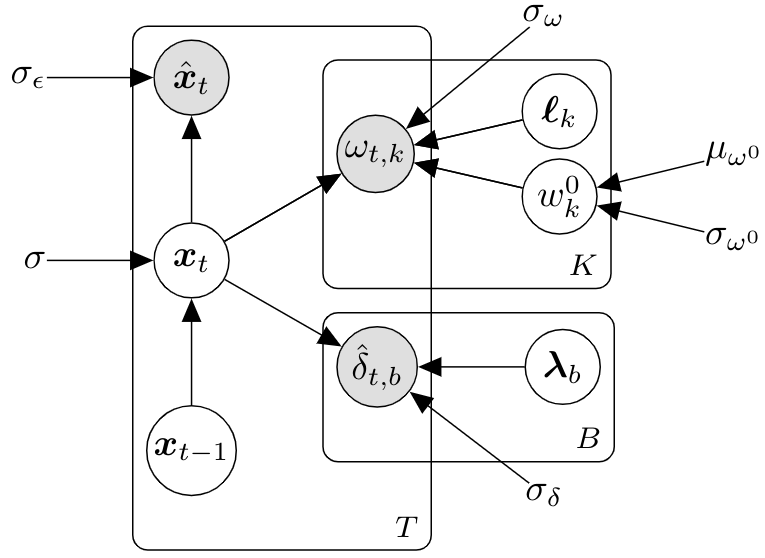

In [2]:
Image(filename='beacon_model.png', width = 300) 

In [3]:
display(object_to_markdown(BeaconModel.model))

```python
def model(
    self,
    mini_batch_index,
    mini_batch_length,
    mini_batch_time,
    mini_batch_position,
    mini_batch_position_mask,
    mini_batch_wifi,
    mini_batch_wifi_mask,
    mini_batch_beacon,
    mini_batch_beacon_mask,
    annealing_factor=1.0,
):

    pyro.module("beacon_model", self)

    T_max = mini_batch_time.shape[-1]
    K = self.K
    B = self.B

    relaxed_floor_dist = dist.Normal(
        self.floor_uniform.mean, self.floor_uniform.stddev
    ).to_event(1)

    sigma = torch.tensor(self.prior_params["sigma"], device=device)
    sigma_eps = torch.tensor(self.prior_params["sigma_eps"], device=device)
    mu_omega_0 = torch.tensor(self.prior_params["mu_omega_0"], device=device)
    sigma_omega_0 = torch.tensor(self.prior_params["sigma_omega_0"], device=device)
    sigma_omega = torch.tensor(self.prior_params["sigma_omega"], device=device)
    sigma_delta = torch.tensor(self.prior_params["sigma_delta"], device=device)

    with poutine.scale(None, annealing_factor):

        with pyro.plate("mini_batch", len(mini_batch_index)):

            x_0 = sample("x_0", relaxed_floor_dist)
            x = torch.zeros(
                x_0.shape[:-1] + (T_max,) + x_0.shape[-1:],  # Batch dims, time, x/y
                dtype=mini_batch_position.dtype,
                device=device,
            )
            x[..., 0, :] = x_0

            for t in pyro.markov(range(1, T_max)):
                x[..., t, :] = sample(
                    f"x_{t}",
                    dist.Normal(x[..., t - 1, :], sigma)
                    .to_event(1)
                    .mask(t < mini_batch_length),
                )

    with pyro.plate("x_observed", mini_batch_position_mask.sum()):
        sample(
            "x_hat",
            dist.Normal(x[..., mini_batch_position_mask, :], sigma_eps).to_event(1),
            obs=mini_batch_position[mini_batch_position_mask],
        )

    any_wifi_is_observed = mini_batch_wifi_mask.any(dim=-1)

    with plate("wifis", K):

        with poutine.scale(None, annealing_factor):
            omega_0 = sample("omega_0", dist.Normal(mu_omega_0, sigma_omega_0))
            wifi_location = sample("wifi_location", relaxed_floor_dist)

        distance = torch.cdist(x[..., any_wifi_is_observed, :], wifi_location)
        with plate("wifi_is_observed", any_wifi_is_observed.sum()):
            signal_strength = omega_0 - 2 * torch.log(distance)
            omega = sample(
                "omega",
                dist.Normal(signal_strength, sigma_omega).mask(
                    mini_batch_wifi_mask[any_wifi_is_observed]
                ),
                obs=mini_batch_wifi[any_wifi_is_observed],
            )

    any_beacon_is_observed = mini_batch_beacon_mask.any(dim=-1)

    with plate("beacons", B):

        with poutine.scale(None, annealing_factor):
            beacon_location = sample("beacon_location", relaxed_floor_dist)

        distance = torch.cdist(x[..., any_beacon_is_observed, :], beacon_location)
        with plate("beacon_is_observed", any_beacon_is_observed.sum()):
            # Probably not the most suitable distribution
            delta = sample(
                "delta",
                dist.Normal(distance, sigma_delta).mask(
                    mini_batch_beacon_mask[any_beacon_is_observed]
                ),
                obs=mini_batch_beacon[any_beacon_is_observed],
            )

    return x, wifi_location, beacon_location
```

In [4]:
torch.manual_seed(123)
beacon_model = BeaconModel(floor_data)

Like the wifi model, the prior on location of the beacons is also simply a gaussian distribution covering the floor area. We may sample the positions from the prior:

In [5]:
x, wifi_location, beacon_location = beacon_model.model(*mini_batch_train)

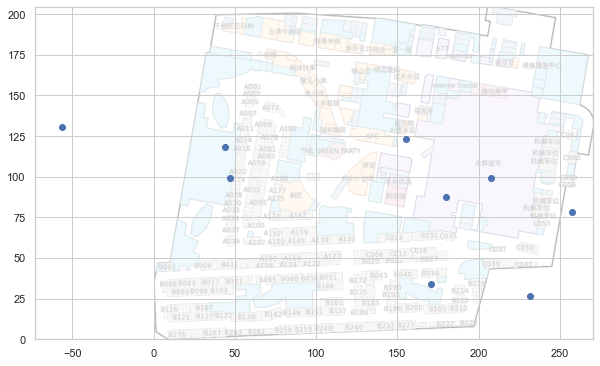

In [6]:
plt.figure(figsize=(10,8))
plt.imshow(floor_image, extent=(0, floor_width, 0, floor_height), alpha=0.3)
plt.scatter(*beacon_location.T)
plt.show()

As for the guide function, the beacon positions are included using a mean field approximation with diagonal variance. The remaining part of the guide function remains the same.

In [7]:
object_to_markdown(BeaconModel.guide)

```python
def guide(
    self,
    mini_batch_index,
    mini_batch_length,
    mini_batch_time,
    mini_batch_position,
    mini_batch_position_mask,
    mini_batch_wifi,
    mini_batch_wifi_mask,
    mini_batch_beacon,
    mini_batch_beacon_mask,
    annealing_factor=1.0,
):

    pyro.module("beacon_model", self)

    T_max = mini_batch_time.shape[-1]
    K = self.K
    B = self.B

    location = torch.zeros((len(mini_batch_index), T_max, 2), device=device)
    scale = torch.zeros((len(mini_batch_index),), device=device)

    for i, (index, length) in enumerate(zip(mini_batch_index, mini_batch_length)):
        l, s = self.trace_guides[index](mini_batch_time[i, :length].unsqueeze(1))
        location[i, :length, :] = l
        scale[i] = s

    with poutine.scale(None, annealing_factor):

        with pyro.plate("mini_batch", len(mini_batch_index)):

            for t in pyro.markov(range(0, T_max)):
                sample(
                    f"x_{t}",
                    dist.Normal(location[:, t, :], scale.view(-1, 1))
                    .to_event(1)
                    .mask(t < mini_batch_length),
                )

        with plate("wifis", K):
            sample("omega_0", dist.Normal(self.mu_q, self.log_sigma_q.exp()))
            sample(
                "wifi_location",
                dist.Normal(
                    self.wifi_location_q, self.wifi_location_log_sigma_q.exp()
                ).to_event(1),
            )

        with plate("beacons", B):
            sample(
                "beacon_location",
                dist.Normal(
                    self.beacon_location_q, self.beacon_location_log_sigma_q.exp()
                ).to_event(1),
            )

    return location, scale
```

## Model Training
As with the other models, we used hyperparameter search using `optuna` in order to figure out reasonable choices for optimization algorithm, learning rate etc. Below we present the results from the best trial. First, the model is restored from a checkpoint.

In [8]:
checkpoint = torch.load(f"../checkpoints/beacon_hparam_042.pt", map_location="cpu")
beacon_model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

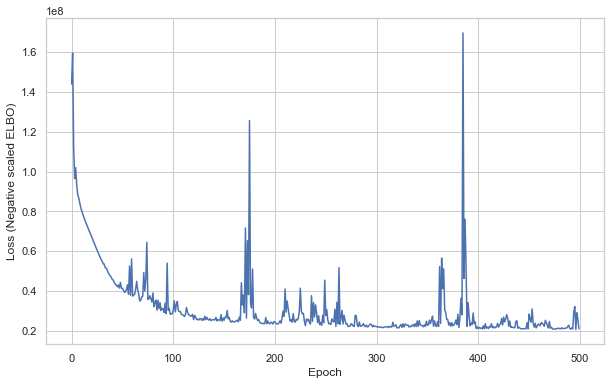

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(checkpoint["loss_history"])
plt.xlabel("Epoch")
plt.ylabel("Loss (Negative scaled ELBO)")
plt.show()

Below, we plot the aproximate posteriors of some of trace curves that were included in the training set.

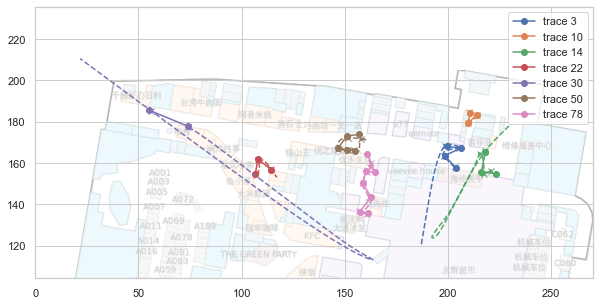

In [10]:
plt.figure(figsize=(10, 5))
plt.imshow(floor_image, extent=(0, floor_width, 0, floor_height), alpha=0.3)
plot_traces(beacon_model, mini_batch_train)
plt.axis("equal");
plt.ylim((140, 200))
plt.legend()
plt.show()

the variational posterior seems to fit the actual observations well (marked with crosses), however does seem to stray a bit too far from the shortest path between each point. This may be because the model is trying to fit the curves as well as possible without moving the actual beacon positions.

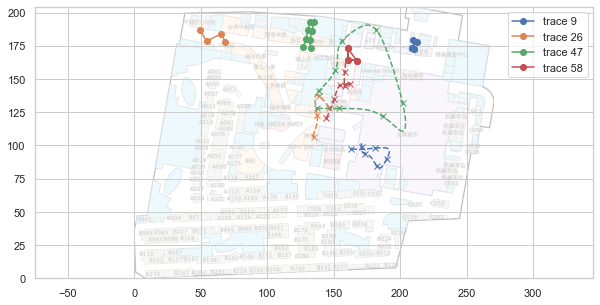

In [18]:
plt.figure(figsize=(10, 5))
plt.imshow(floor_image, extent=(0, floor_width, 0, floor_height), alpha=0.3)
plot_traces(beacon_model, mini_batch_test)
plt.axis("equal");

plt.legend()
plt.show()

Compared with the wifi model, the traces infered without the waypoints are still not very good. Compared to the wifi model, the traces are at least within the building and not $\approx 1.5$ km outside the building, which is an improvement all things considered.

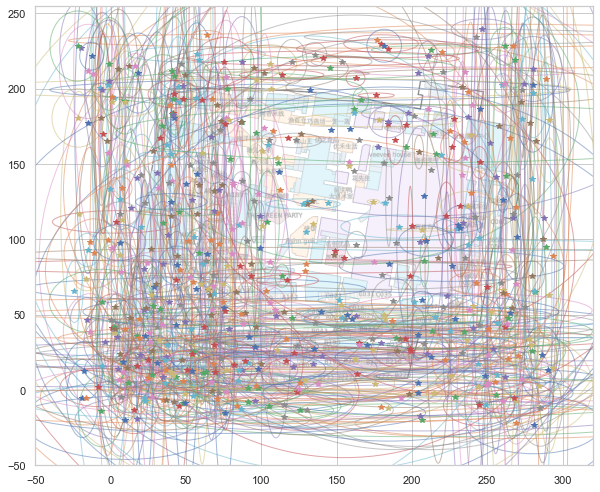

In [12]:
plt.figure(figsize=(10, 10))
plt.imshow(floor_image, extent=(0, floor_width, 0, floor_height), alpha=0.5)
plot_wifi(beacon_model)
plt.xlim(-50, floor_width + 50)
plt.ylim(-50, floor_height + 50)
plt.show()

Again the approximative posterior of the wifi router locations seem to form some structure. Some are very certain, some are very uncertain. Let us again have a look on the interpolated wifi from the exploratory notebook against the approximative posterior: 

In [13]:
from src.plotting import get_wifi_strengths

wifi_indices = [0, 1, 2, 3, 4, 5]
wifi_bssids = [floor_data.bssids_[i] for i in wifi_indices]
wifi_strengths = get_wifi_strengths(floor_data, wifi_bssids)

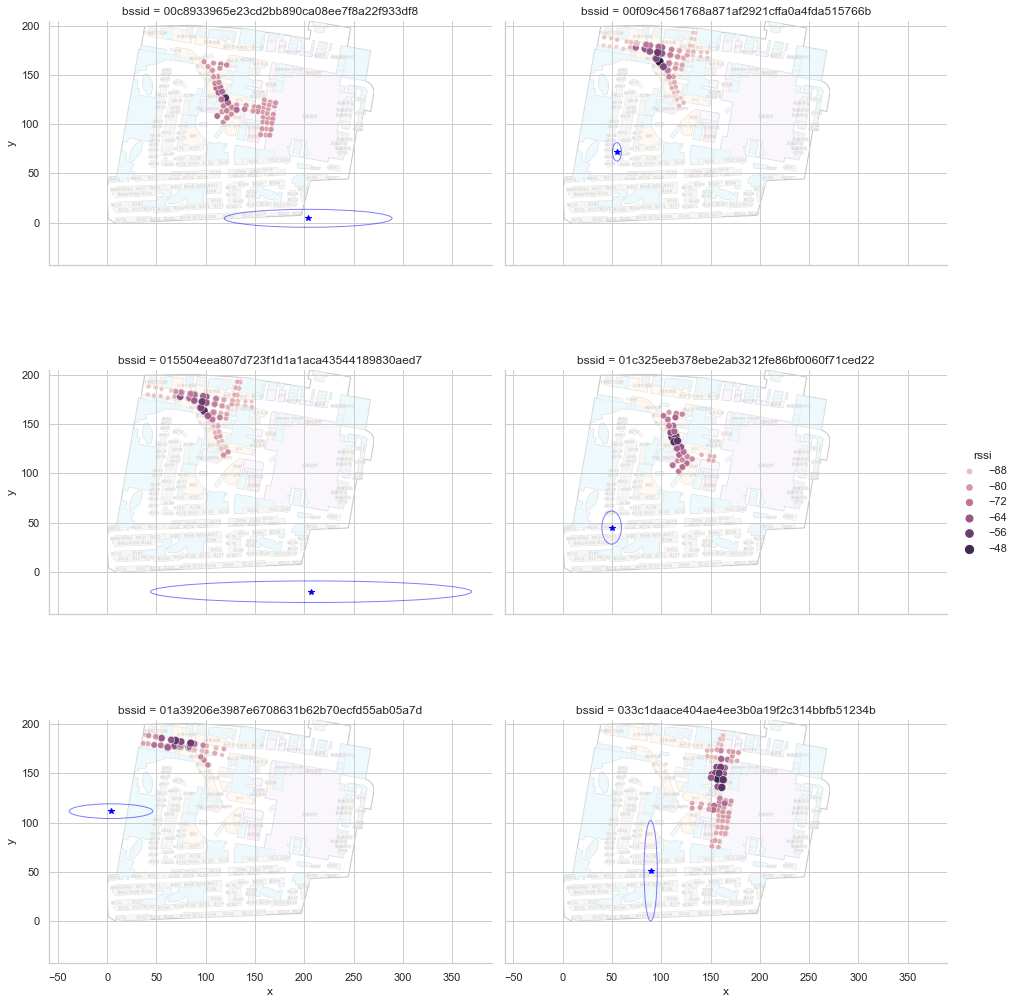

In [14]:
fg = sns.relplot(data=wifi_strengths, x="x", y="y", col="bssid", col_wrap=2, hue="rssi", size='rssi', aspect=floor_width/floor_height)
for bssid, ax in fg.axes_dict.items():
    ax.imshow(floor_data.image, extent=(0, floor_width, 0, floor_height), alpha=0.3)
    plot_wifi(beacon_model, [wifi_bssids.index(bssid)], ax=ax, color="blue")

For these 6 wifi router locations, the emperical locations and the infered locations does not seem to match. Some of the wifi routers locations is even certain that the location are outside the mall - this should indeed not be the case. 

Let us now have a look on the interpolated beacon distance and the infered beacon location: 

In [15]:
from src.plotting import get_beacon_distances

In [16]:
beacon_distances  = get_beacon_distances(floor_data, floor_data.beacon_ids_)
beacon_uuids = floor_data.beacon_ids_

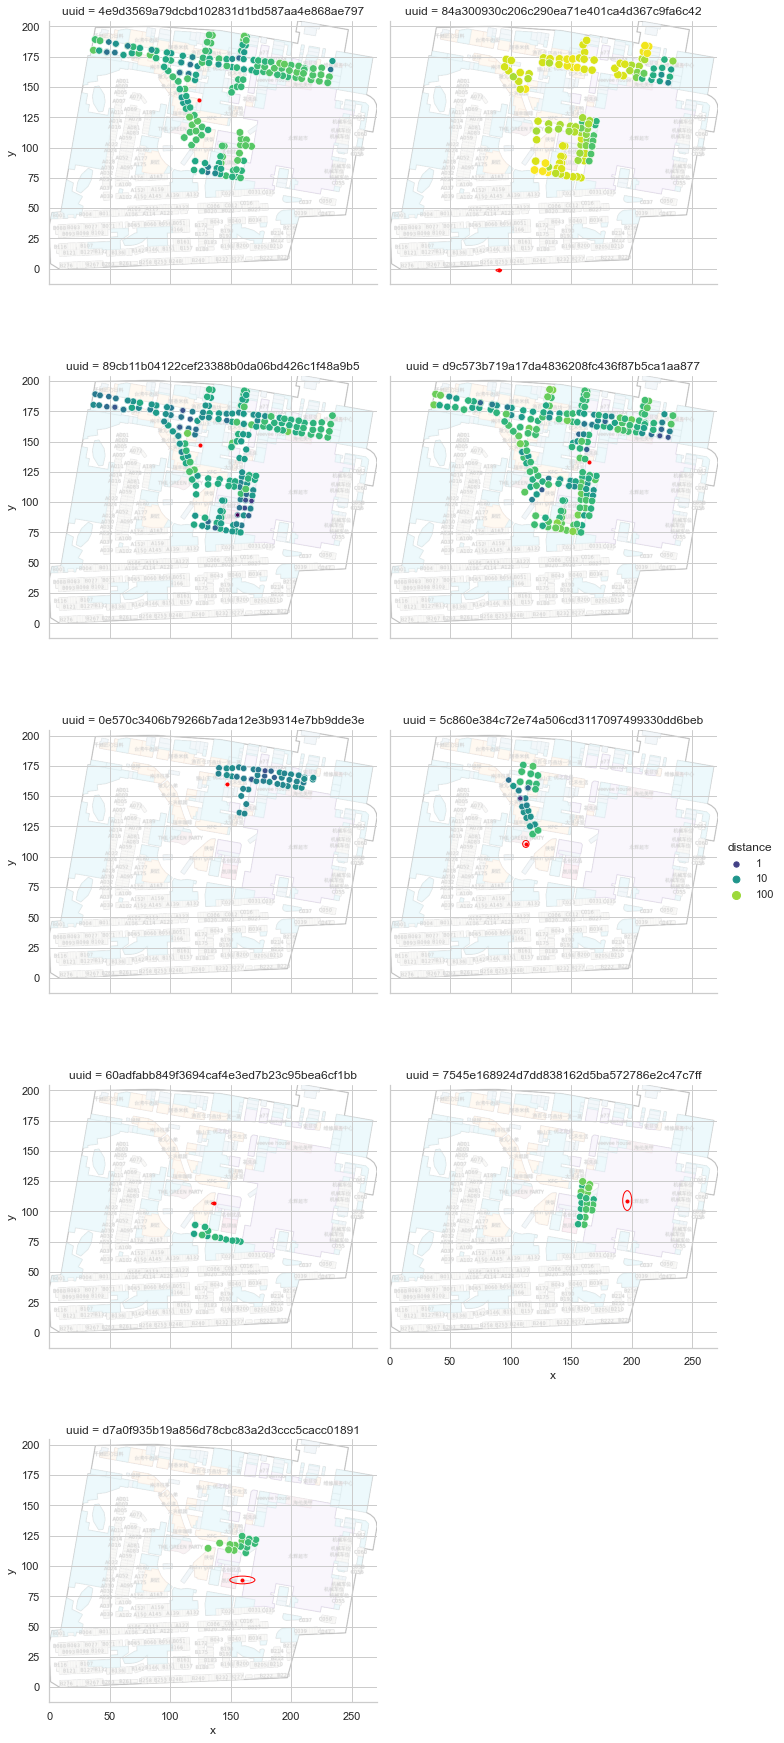

In [17]:
from matplotlib.colors import LogNorm
fg = sns.relplot(data=beacon_distances, x="x", y="y", size="distance", hue="distance", col="uuid", col_wrap=2, palette="viridis",    hue_norm=LogNorm(), 
    size_norm=LogNorm())
for uuid, ax in fg.axes_dict.items():
    ax.imshow(floor_data.image, extent=(0, floor_width, 0, floor_height), alpha=0.3)
    plot_beacons(beacon_model, [beacon_uuids.index(uuid)], ax=ax, color="red",  marker="*")

The beacon location red dots, is fairly confident (i.e. small location variance parameter). Since we allowed the beacon distance to vary with a standard devirations of 10 meters, looking at the values of some of the beacon signals, they do seem to respect the distance to the beacon quite well, at least compared to wifi positions.